In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# If on Google Colab:
# * Mount google drive
# * Install required modules
try:
    from google.colab import drive
    is_colab_kernel = True
except ModuleNotFoundError:
    is_colab_kernel = False

if is_colab_kernel:    
    google_drive_mount = '/content/drive/'
    drive.mount(google_drive_mount)  # https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA
    proj_dir = google_drive_4/zQDy1XoZJh48IiuM05v781eWFnW2mF3Yc8za0UBMUg6PxSPaKU3PLnAmount + 'My Drive/colab/pytorch-challenge'
    
    

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


NameError: ignored

In [3]:
# Change to project directory, set environment variable $PROJ_DIR

if is_colab_kernel:
    proj_dir = google_drive_mount + 'My Drive/colab/pytorch-challenge'
    %mkdir -p "$proj_dir"
    %cd -q "$proj_dir"
else:  # Running on local machine, assume we are already in project directory
    proj_dir = %pwd  

%env PROJ_DIR = $proj_dir
print('Current working directory:', proj_dir)

env: PROJ_DIR=/content/drive/My Drive/colab/pytorch-challenge
Current working directory: /content/drive/My Drive/colab/pytorch-challenge


In [4]:
# Install PyTorch if on Google Colab

if is_colab_kernel:
  import os
  from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

  platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
  cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\10/'
  accelerator = cuda_output[0] if os.path.exists('/dev/nvidia0') else 'cpu'
  print("Accelerator = {}, Platform = {}".format(accelerator, platform))

  version='1.0.0'  # Change this when a new version is released
  torch_url=f"http://download.pytorch.org/whl/{accelerator}/torch-{version}-{platform}-linux_x86_64.whl"
  torch_pkg = os.path.basename(torch_url)

  # Download torch if needed
  if not os.path.exists(torch_pkg):
      !wget --continue $torch_url

  # Install PyTorch if it is not installed
  !pip show torch &> /dev/null || pip install -U --progress-bar=pretty "{torch_pkg}" torchvision pillow==4.1.1
  %reload_ext autoreload
  %autoreload

Accelerator = cu90, Platform = cp36-cp36m


In [5]:
%%bash
# [[ ! -e /colabtools ]] && exit  # Continue only if running on Google Colab

set -eu  # Exit on command failure or unset variable

# Download the category name mapping file if needed
wget -qN 'https://raw.githubusercontent.com/udacity/pytorch_challenge/master/cat_to_name.json'

# Download / extract the datasets if needed
data_file="$PROJ_DIR/flower_data.zip"
category_labels=
data_dir=$(readlink -f 'flower_data')  # Convert to absolute path

if [[ -d "$data_dir" ]]; then
  echo "Dataset already unzipped."
  ls -ld "$data_dir"/*
  exit
fi

if [[ -s "$data_file" ]]; then
  echo "Downloaded dataset already exists."
else
  echo "Please wait while dataset downloads..."
  wget --continue 'https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip'
fi

echo "Unzipping $data_file..."
unzip -uq "$data_file" | tail -n3
rm "$data_file"  # Remove file to save disk space

ls -ld "$data_dir"/*

Dataset already unzipped.
drwx------ 104 root root 4096 Jan 15  2018 /content/drive/My Drive/colab/pytorch-challenge/flower_data/train
drwx------ 104 root root 4096 Jan  9 03:03 /content/drive/My Drive/colab/pytorch-challenge/flower_data/valid


In [6]:
# Check if CUDA is available

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
    print('CUDA is not available.  Training on CPU ...')
    if is_colab_kernel:
        print('You should enable GPUs for speed-up.')
else:
    print('CUDA is available!  Training on GPU ...')

# Set device for .to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# http://pytorch.org/
import numpy as np
import matplotlib.pyplot as plt
import time
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


CUDA is available!  Training on GPU ...


In [0]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485,0.456,0.406],
                                                           [0.229,0.224,0.255])])

test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485,0.456,0.406],
                                                           [0.229,0.224,0.255])])


In [0]:
# TODO: Load the datasets with ImageFolder
train_dataset = ImageFolder('/content/drive/My Drive/colab/pytorch-challenge/flower_data/train', transform=train_transforms)
test_dataset =  ImageFolder('/content/drive/My Drive/colab/pytorch-challenge/flower_data/valid', transform=test_transforms)
# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=True)

In [9]:
!wget https://raw.githubusercontent.com/udacity/pytorch_challenge/master/cat_to_name.json


--2019-01-09 10:45:39--  https://raw.githubusercontent.com/udacity/pytorch_challenge/master/cat_to_name.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2218 (2.2K) [text/plain]
Saving to: ‘cat_to_name.json.1’

cat_to_name.json.1  100%[===================>]   2.17K  --.-KB/s    in 0.001s  

2019-01-09 10:45:39 (2.51 MB/s) - ‘cat_to_name.json.1’ saved [2218/2218]



In [10]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
print(f"DataSet of Size : {len(train_dataset)} images")
print(f"Validation of size {len(test_dataset)} images")
print(f"Number of classes : {len(cat_to_name)}")

DataSet of Size : 6552 images
Validation of size 818 images
Number of classes : 102


In [0]:
def imshow(image, ax=None, title=None, color="black"):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image)
    if title != None:
        ax.set_title(title, color=color)
    return ax

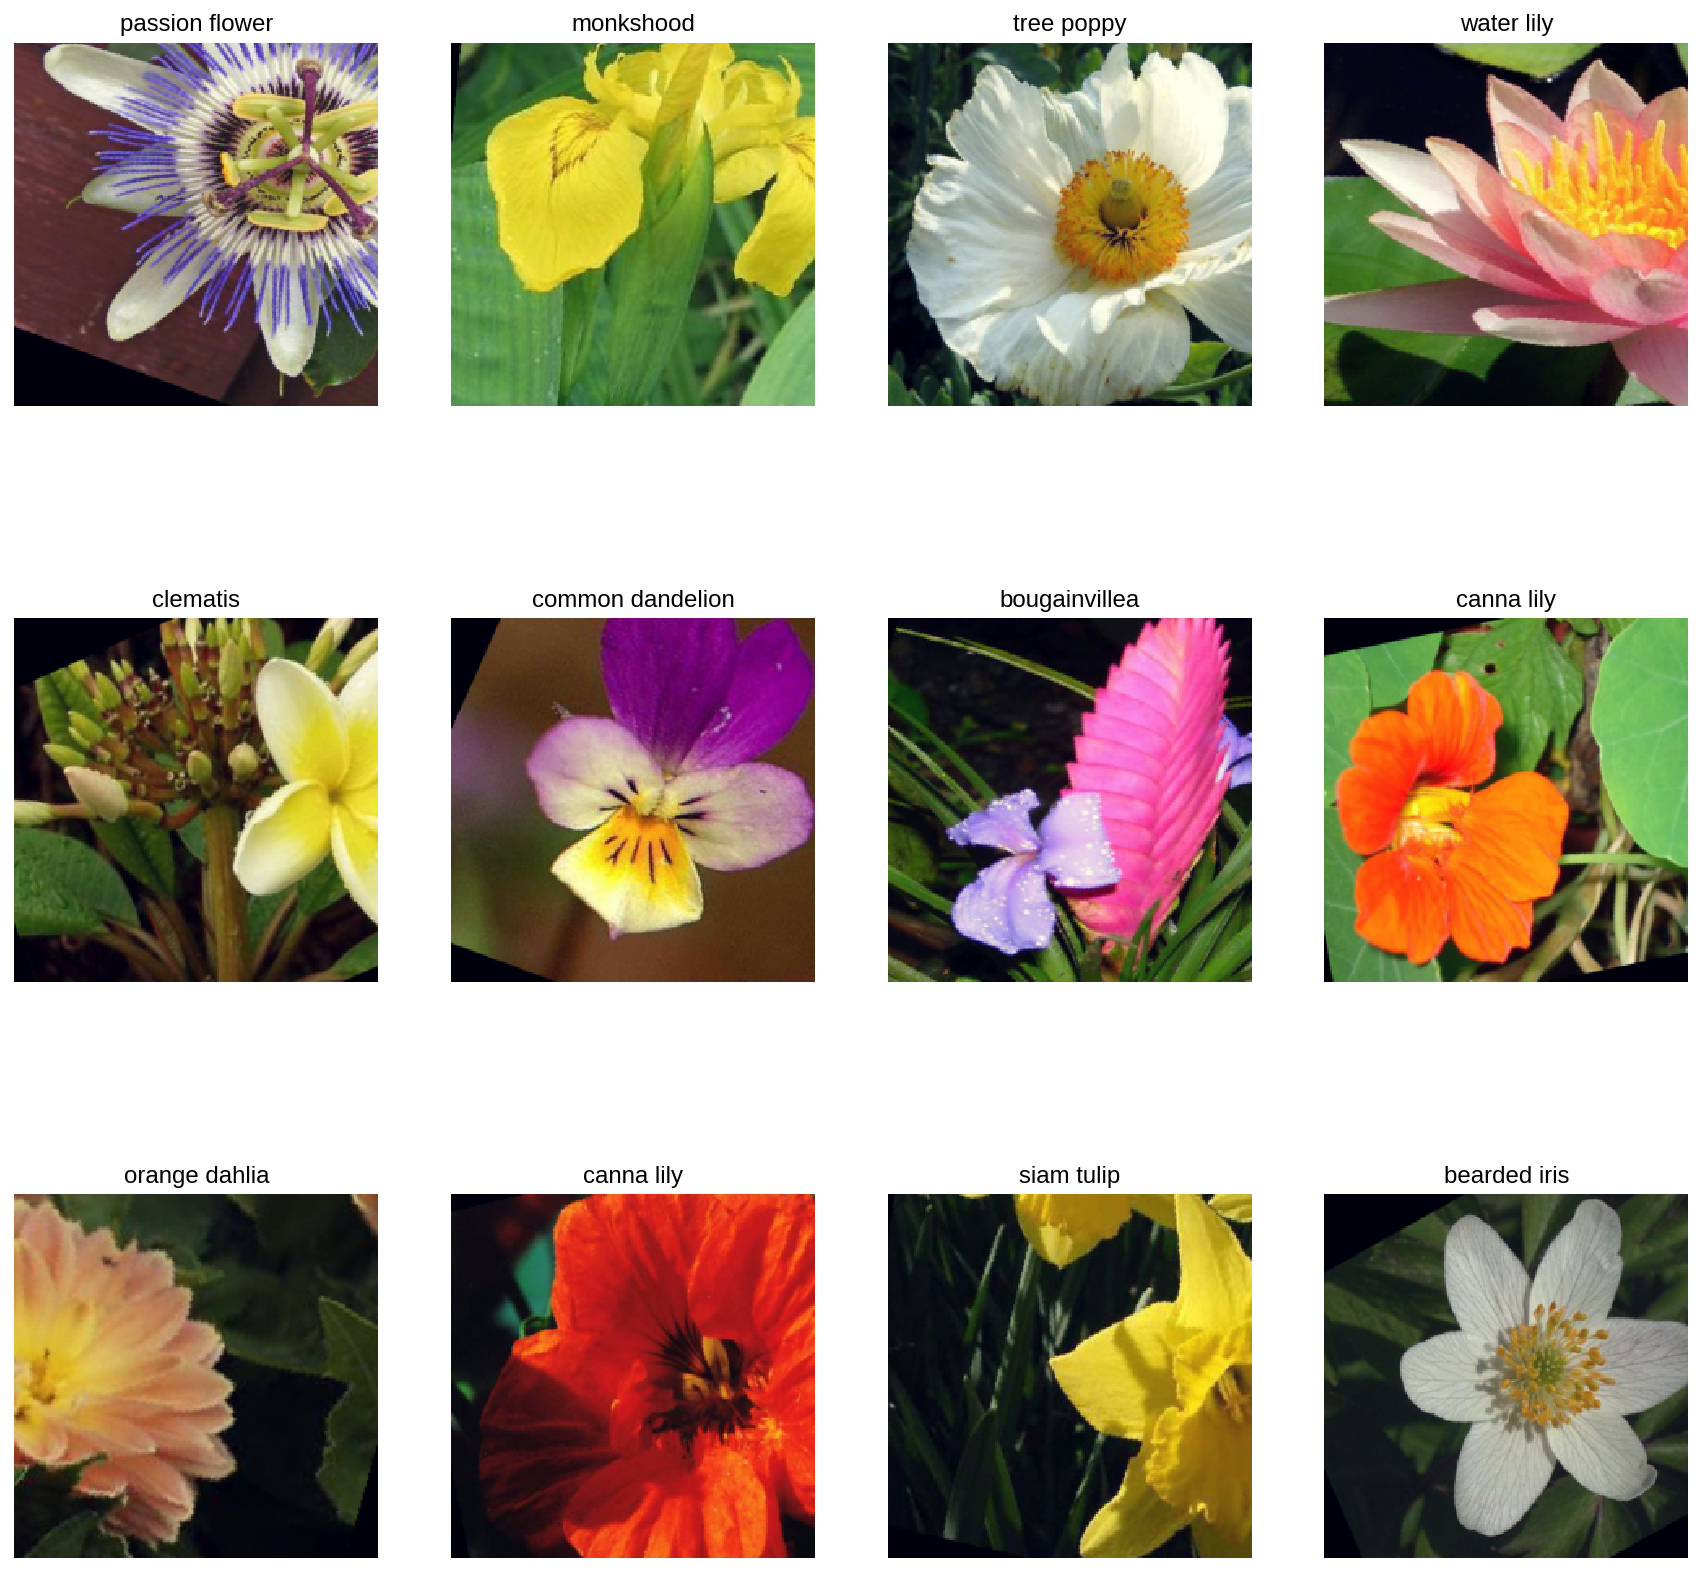

In [12]:
dataiter = iter(train_loader)
imgs, labels = dataiter.next()

fig = plt.figure(figsize=(15, 15))

for i in range(1,13):
    sub = fig.add_subplot(3, 4, i)
    imshow(imgs[i], sub,
           title=cat_to_name[str(labels[i].item())])

In [13]:
# TODO: Build and train your network

# we load the model
model = models.resnet152(pretrained=True)
    
print(model)
for name, child in model.named_children():
  print(name + ' is frozen')
  for param in child.parameters():
    param.requires_grad = False

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [14]:
for name, child in model.named_children():
  print(name + ' is frozen')
  for param in child.parameters():
    param.requires_grad = False

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is frozen
layer4 is frozen
avgpool is frozen
fc is frozen


In [15]:
model.fc = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU(), nn.Dropout(),
                                 nn.Linear(1024, 102),
                                 nn.LogSoftmax(dim=1))
                                
print(model.fc)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"devive : {device}")
model.to(device);

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5)
  (3): Linear(in_features=1024, out_features=102, bias=True)
  (4): LogSoftmax()
)
devive : cuda


In [0]:
lr = 2e-2
epochs = 30 
print_every = 50
moving_train_loss=0
accuracys = []
train_losses = []
test_losses = []
step = 0
# Loss
criterion = torch.nn.NLLLoss()
# optimizer
optimizer = optim.SGD(model.fc.parameters(),lr=lr,momentum=0.9, nesterov=True, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.4)

In [0]:
# start the watch
training_time = time.time()
last_frozen = 4

for epoch in range(epochs):
    #for current epoch
    moving_train_loss = 0
    scheduler.step(epoch)
    
    if(epoch+1%10 == 0):
      for name, child in model.named_children():
        if name == "layer"+str(last_frozen):
          last_frozen -= 1
          print(name + ' is unfrozen')
          for param in child.parameters():
            param.requires_grad = True
      lr = lr/20
      optimizer = optim.SGD(filter(lambda x:x.requires_grad, model.parameters()), lr=lr, weight_decay=1e-5, momentum=0)
      scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.8)
  
    # iterate through the batches
    for imgs, labels in train_loader:
        # move the batch to the device
        imgs, labels = imgs.to(device), labels.to(device)
        step += 1
        # forward step
        optimizer.zero_grad()
        out = model.forward(imgs)
        
        train_loss = criterion(out, labels)
        moving_train_loss += train_loss.item()
        #backward
        train_loss.backward()

        optimizer.step()
        # test the acuracy on the validation set
        if step % print_every == 0:
            # iterate over the test batches
            accuracy = 0
            moving_test_loss = 0
            model.eval()
            with torch.no_grad():
                for imgs, labels in test_loader:
                    # transfer to the device
                    imgs, labels  = imgs.to(device), labels.to(device)
                    # turn off drop out, batch norm ..  and other stuff

                    # forward step
                    out = model.forward(imgs)
                    # calculate the loss
                    test_loss = criterion(out, labels)
                    moving_test_loss += test_loss.item()


                    pb_test = torch.exp(out)
                    top_p, top_class = pb_test.topk(1, dim=1)
                    equals = (top_class == labels.view(top_class.shape))
                    accuracy +=  torch.mean(equals.type(torch.FloatTensor)).item()

                    #turn the training mode again
            model.train()
                
            accuracys.append(accuracy/len(test_loader))
            train_losses.append(moving_train_loss/len(train_loader))
            test_losses.append(moving_test_loss/len(test_loader))
            
            print(f"Time: {time.time() - training_time:.2f} .. Epoch {epoch+1}/{epochs}.. ",
                  f"Train Loss:{moving_train_loss/len(train_loader):.3f} ..",
                  f"Test Loss: {moving_test_loss/len(test_loader):.3f}",
                  f"Accuracy: {accuracy/len(test_loader):.3f}")
                  
training_time = time.time() - training_time

Time: 99.79 .. Epoch 1/30..  Train Loss:1.552 .. Test Loss: 3.129 Accuracy: 0.363
Time: 199.96 .. Epoch 1/30..  Train Loss:2.535 .. Test Loss: 1.769 Accuracy: 0.570
Time: 298.72 .. Epoch 2/30..  Train Loss:0.374 .. Test Loss: 1.482 Accuracy: 0.636
Time: 399.07 .. Epoch 2/30..  Train Loss:0.996 .. Test Loss: 1.096 Accuracy: 0.729
Time: 499.25 .. Epoch 2/30..  Train Loss:1.517 .. Test Loss: 0.867 Accuracy: 0.787
Time: 597.84 .. Epoch 3/30..  Train Loss:0.442 .. Test Loss: 0.886 Accuracy: 0.799
Time: 697.87 .. Epoch 3/30..  Train Loss:0.918 .. Test Loss: 0.785 Accuracy: 0.802
Time: 796.62 .. Epoch 4/30..  Train Loss:0.060 .. Test Loss: 0.931 Accuracy: 0.749
Time: 896.79 .. Epoch 4/30..  Train Loss:0.532 .. Test Loss: 0.795 Accuracy: 0.789
Time: 996.88 .. Epoch 4/30..  Train Loss:0.938 .. Test Loss: 0.715 Accuracy: 0.815
Time: 1095.70 .. Epoch 5/30..  Train Loss:0.205 .. Test Loss: 0.677 Accuracy: 0.827
